In [8]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


In [11]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 58.8 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [13]:
df = pd.read_csv("/content/drive/MyDrive/SMT 7/Pemrosesan Teks Teori/Hasil_Preprocessing (1).csv")
texts = df["full_text"].astype(str)

In [15]:
spam_keywords = [
    r"promo", r"diskon", r"beli sekarang", r"kode voucher",
    r"giveaway", r"link di bio", r"open order", r"gratis ongkir",
    r"kunjungi", r"follow", r"cashback", r"dm ya", r"order",
    r"jual", r"ready stock", r"preorder", r"wa.me", r"http",
    r"https", r"bit.ly", r"shopee", r"tokopedia"
]

def is_spam(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    for keyword in spam_keywords:
        if re.search(keyword, text):
            return True
    return False

df_clean = df[~df["full_text"].apply(is_spam)].reset_index(drop=True)

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopwords_indo = set(stopwords.words("indonesian"))

extra_stopwords = {
    # slang umum
    "gak","ga","nggak","ngga","nga","aja","ajah","aj","kayak","kyk","kaya",
    "gitu","gituh","gini","begitu","begini",

    # kata pengisi / filler
    "nih","sih","dong","deh","mah","loh","lho","lah","pun","tuh","kan","kok",
    "yah","ya","yaa","yaaa","yaaaa","yaaah","yaampun","yaaampun",

    # kata ganti orang
    "gw","gue","gua","lu","loe","lo","kamu","km","kmu","dia","mereka",

    # ekspresi & tawa
    "wkwk","wk","wkwkwk","wkwkwkwk","haha","hahaha","hehe","hehehe",
    "hihi","huhu","huu","wew","weh","wow","woow","wooow",

    # kata pujian / reaksi
    "oke","ok","sip","mantap","mantapp","mantappp","mantul",

    # singkatan umum
    "yg","yng","dgn","dg","sdh","udah","dah","sudah","sm","sama",
    "tp","tapi","biar","dll","dst","jd","jg","nt",
}

stopwords_all = stopwords_indo.union(extra_stopwords)

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopwords_indo = set(stopwords.words("indonesian"))

extra_stopwords = {
    # 1. Noise & Artefak Twitter/Media Sosial (Sangat direkomendasikan dihapus)
    "https", "co", "t", "amp",  # "amp" sisa dari &amp;
    "rt", "u", "1", "2", "3",    # Angka seringkali tidak bermakna di sini

    # 2. Kata Slang & Singkatan Umum (Tidak ada di library standar)
    "yg", "gak", "ga", "aja", "tuh", "sih",
    "kalo", "udah", "dr", "krn", "utk", "jd",
    "karna", "krna", "jg", "juga", "ni", "tu",
    "nak", "sbb", "tak", "je", "kat", # Slang/kata Melayu umum (muncul di data)

    # 3. Kata Penghubung/Umum yang Sering Muncul (High Frequency Words)
    "ini", "itu", "dan", "di", "ke", "dari",
    "yang", "ada", "untuk", "dengan", "dalam",
    "pada", "atau", "adalah", "karena", "seperti",
    "bisa", "mau", "buat", "jadi", "kan", "ya",
    "nya", "pun", "kok", "lah", "dong", "deh"
}


stopwords_all = stopwords_indo.union(extra_stopwords)


def clean_text(text):
    text = text.lower()

    text = re.sub(r"http\S+|www\S+|bit\.ly/\S+", "", text)
    text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\brt\b", "", text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"\s{2,}", " ", text).strip()
    words = text.split()
    words = [w for w in words if w not in stopwords_all and len(w) > 2]
    words = [stemmer.stem(w) for w in words]
    words = [w for w in words if len(w) > 1]
    return " ".join(words)


df["clean"] = df["full_text"].apply(clean_text)
df = df[df["clean"].str.strip() != ""]


K optimal (Elbow Ratio): 5


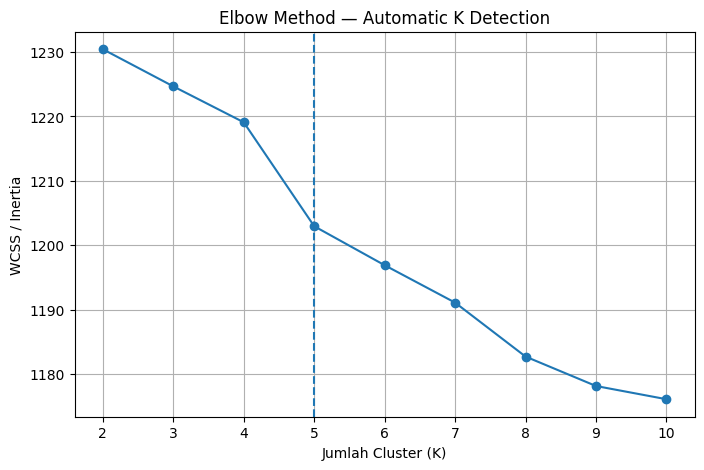

In [20]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["clean"])

K = range(2, 11)
inertia = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertia.append(km.inertia_)

ratios = []
for i in range(1, len(inertia)):
    ratios.append((inertia[i-1] - inertia[i]) / inertia[i-1])

best_k = ratios.index(max(ratios)) + 3

print("K optimal (Elbow Ratio):", best_k)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.axvline(best_k, linestyle='--')
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("WCSS / Inertia")
plt.title("Elbow Method — Automatic K Detection")
plt.grid(True)
plt.show()

In [21]:
kmeans_final = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init="auto"
)

labels = kmeans_final.fit_predict(X)
df["cluster"] = labels

feature_names = np.array(tfidf.get_feature_names_out())

print("\n=== TOP WORDS PER CLUSTER ===")

X_dense = X.toarray()

for c in range(best_k):
    # ambil data dalam cluster c
    cluster_docs = X_dense[df["cluster"] == c]

    # jumlahkan bobot TF-IDF
    tfidf_sum = cluster_docs.sum(axis=0)

    # ambil indeks kata terbesar
    top_idx = tfidf_sum.argsort()[-15:][::-1]

    top_words = feature_names[top_idx]

    print(f"\nCluster {c}: {', '.join(top_words)}")


=== TOP WORDS PER CLUSTER ===

Cluster 0: mbg, racun, mbape, prabowo, mutu, korban, siswa, bareng, dapet, orang, sekolah, tingkat, banget, rakyat, stop

Cluster 1: makan, anak, program, gizi, mbg, gratis, lanjutkanmbg, sehat, indonesia, ajar, perintah, racun, nyata, penuhigizindonesia, sekolah

Cluster 2: menu, rokok, batang, mbg, cimarga, tambah, gubernur, banten, variasi, sma, khusus, nasi, makan, biar, singapura

Cluster 3: dapur, spg, kerja, mbgjalanterus, mbg, bgn, angaran, prabowo, anak, triliun, kembali, lanjut, baik, program, ayam

Cluster 4: tkd, gasnow, kayak, ekonomi, mbg, lokal, daerah, bikin, transfer, program, dana, contoh, nunjukin, efisien, efisiensi


In [22]:
count_vect = CountVectorizer(
    max_features=5000,
    min_df=3
)

X_count = count_vect.fit_transform(df["clean"])

n_topics = best_k
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)

lda.fit(X_count)

terms = np.array(count_vect.get_feature_names_out())

print("\n=== TOP WORDS PER TOPIC (LDA) ===")

for i, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[-15:][::-1]
    top_words = terms[top_idx]
    print(f"\nTopic {i}: {', '.join(top_words)}")


=== TOP WORDS PER TOPIC (LDA) ===

Topic 0: mbg, anak, program, sehat, makan, gizi, dapur, kerja, lanjutkanmbg, presiden, prabowo, indonesia, spg, ajar, sekolah

Topic 1: mbg, gizi, makan, program, gratis, bgn, angaran, racun, ayam, dapur, porsi, nasional, anak, siswa, presiden

Topic 2: mbg, makan, menu, sekolah, dapur, nasi, rokok, siswa, racun, orang, mbape, dapet, gue, batang, mah

Topic 3: mbg, tkd, program, gasnow, prabowo, kayak, ekonomi, perintah, bareng, mutu, jalan, lokal, nyata, masyarakat, tingkat

Topic 4: mbg, racun, korban, bandung, barat, cisarua, jabat, siswa, stop, program, temu, evaluasi, habiburokhman, gin, henti


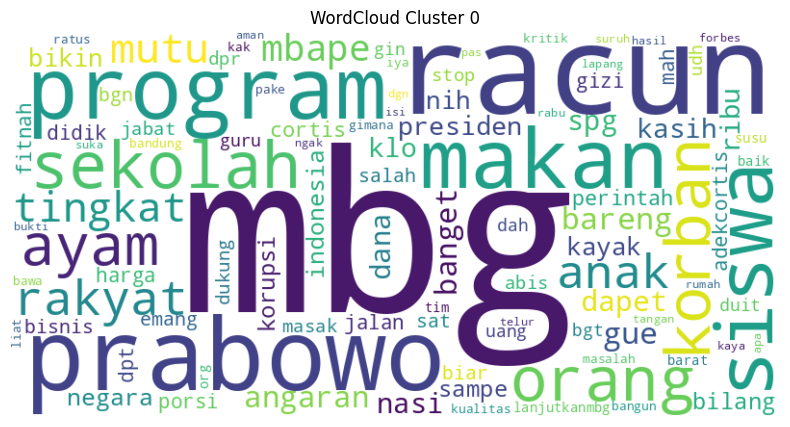

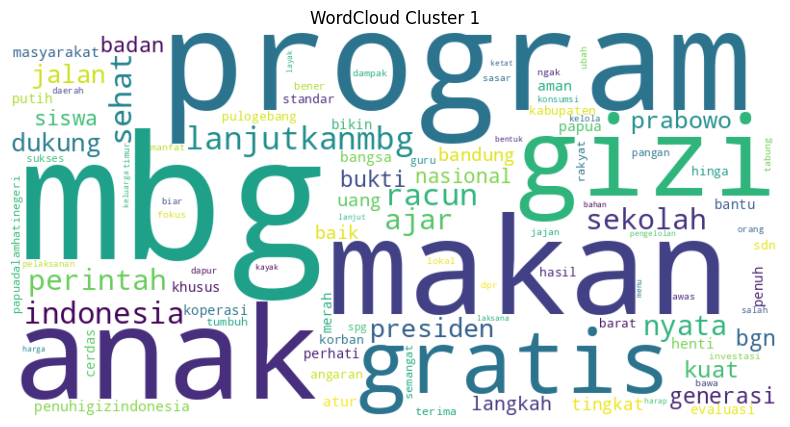

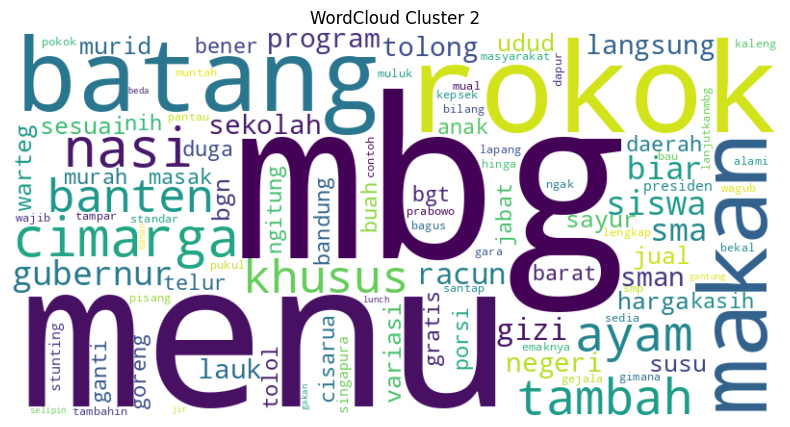

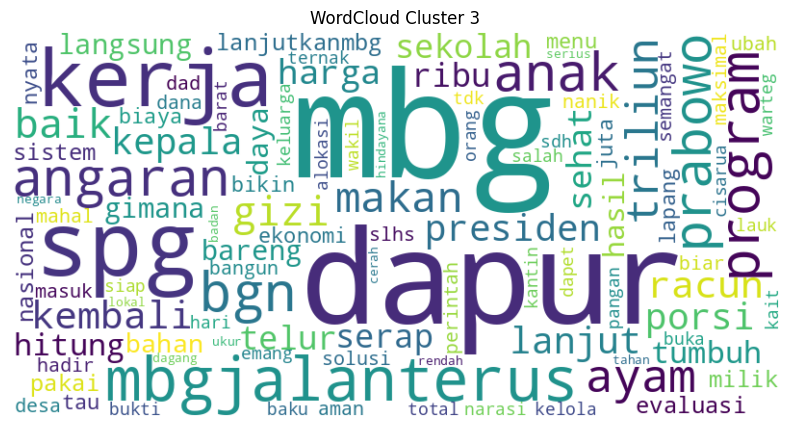

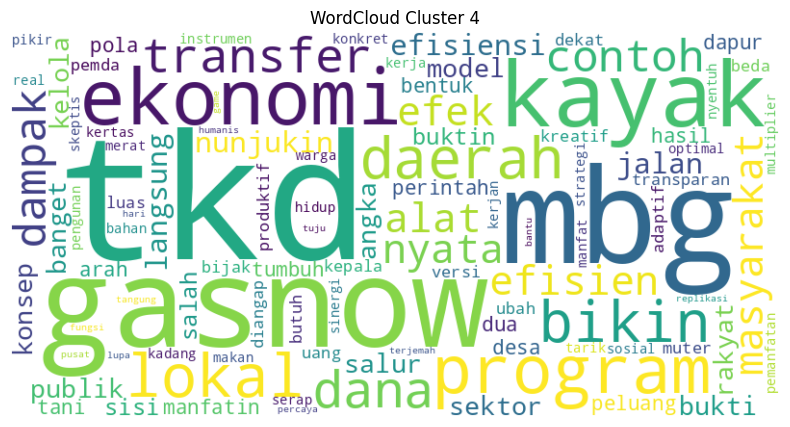

In [25]:
for c in range(best_k):
    cluster_text = df[df["cluster"] == c]["clean"]

    text_joined = " ".join(cluster_text)

    if len(text_joined.strip()) == 0:
        print(f"Cluster {c} kosong → dilewati.")
        continue

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        collocations=False
    ).generate(text_joined)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud Cluster {c}")
    plt.show()